# NBC classification

Merging and Splitting Dataset

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load datasets
train_essays, train_prompts = pd.read_csv('train_essays.csv'), pd.read_csv('train_prompts.csv')

# Merge datasets
merged_data = pd.merge(train_essays, train_prompts, on='prompt_id')

# Split into training and development sets
train_data, dev_data = train_test_split(merged_data, test_size=0.2, random_state=42)


Building Vocabulary and Index

In [16]:
import re
from collections import defaultdict

def tokenize(content):
    return re.findall(r'\b\w+\b', content.lower())

def bvai(data):
    word_freq = defaultdict(int)
    for essay in data['text']:
        for word in set(tokenize(essay)):
            word_freq[word] += 1
    
    vocabulary = [word for word, freq in word_freq.items() if freq >= 5]
    index = {word: idx for idx, word in enumerate(vocabulary)}
    
    return vocabulary, index

vocabulary, index = bvai(train_data)


Calculating Probabilities

In [17]:
def cp(dataSet, vocabList, indexByWord):
    # Setting up counters for individual words and words per class
    countPerWord = defaultdict(int)
    countPerClassAndWord = defaultdict(lambda: defaultdict(int))

    # Counting the total number of entries in the dataset
    totalEntries = len(dataSet)
    
    # Counting entries per each category
    entriesPerCategory = dataSet['generated'].value_counts()

    # Processing each entry in the dataset
    for _, entry in dataSet.iterrows():
        # Extracting unique words from the text
        uniqueWords = set(tokenize(entry['text']))
        
        # Tallying word occurrences
        for word in uniqueWords:
            if word in vocabList:
                countPerWord[word] += 1
                countPerClassAndWord[entry['generated']][word] += 1

    # Calculating word probabilities
    wordProbability = {word: countPerWord[word] / totalEntries for word in vocabList}
    classWordProbability = {
        category: {word: countPerClassAndWord[category][word] / entriesPerCategory[category]
                   for word in vocabList}
        for category in entriesPerCategory.index
    }

    return wordProbability, classWordProbability


# Calculate probabilities using the provided data and parameters
Pred, Pred_c = cp(train_data, vocabulary, index)


Number of human-generated essays: 1375
Number of LLM-generated essays: 450


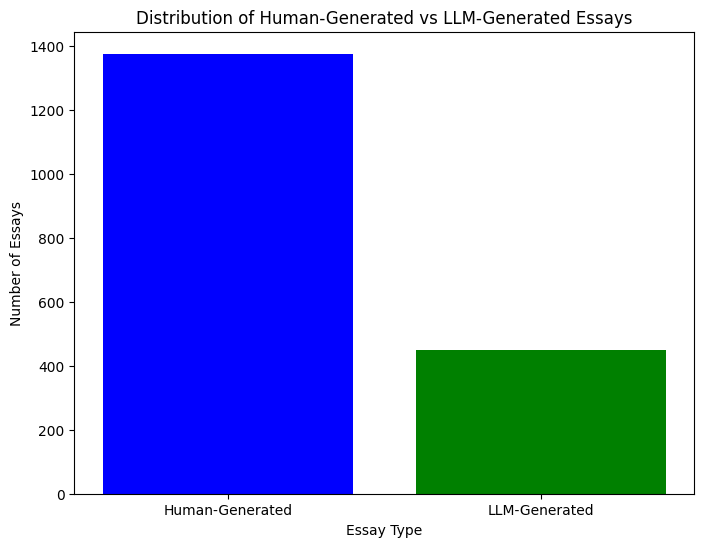

In [18]:
# Count the number of human-generated and LLM-generated essays
essay_counts = train_essays['generated'].value_counts()
print("Number of human-generated essays:", essay_counts.get(0, 0))
print("Number of LLM-generated essays:", essay_counts.get(1, 0))

# Visualize the counts
import matplotlib.pyplot as plt

labels = ['Human-Generated', 'LLM-Generated']
counts = [essay_counts.get(0, 0), essay_counts.get(1, 0)]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['blue', 'green'])
plt.xlabel('Essay Type')
plt.ylabel('Number of Essays')
plt.title('Distribution of Human-Generated vs LLM-Generated Essays')
plt.show()


In [19]:
# Filter and display rows with LLM-generated essays
llm_essays = train_essays[train_essays['generated'] == 1]
print(llm_essays)


            id  prompt_id                                               text  \
704   82131f68          1  This essay will analyze, discuss and prove one...   
740   86fe4f18          1  I strongly believe that the Electoral College ...   
1262  eafb8a56          0  Limiting car use causes pollution, increases c...   
1378  a9213f58          1  Education plays a pivotal role in shaping the ...   
1379  b132f49a          1  Environmental conservation is crucial for sust...   
...        ...        ...                                                ...   
1820  pgg5t2bt          1  The concept of genetic engineering has revolut...   
1821  pgg5t2bu          1  The world of sustainable agriculture is marked...   
1822  pgg5t2bv          1  The field of quantum computing holds the poten...   
1823  pgg5t2bw          1  The concept of conscious consumerism encourage...   
1824  pgg5t2bx          1  The world of space exploration continues to ca...   

      generated  
704           1  
740

Naive Bayes Classifier Implementation and Evaluation

Accuracy with smoothing 0.5: 0.7698630136986301
Accuracy with smoothing 1: 0.7698630136986301
Accuracy with smoothing 2: 0.7671232876712328
Accuracy with smoothing 5: 0.7671232876712328


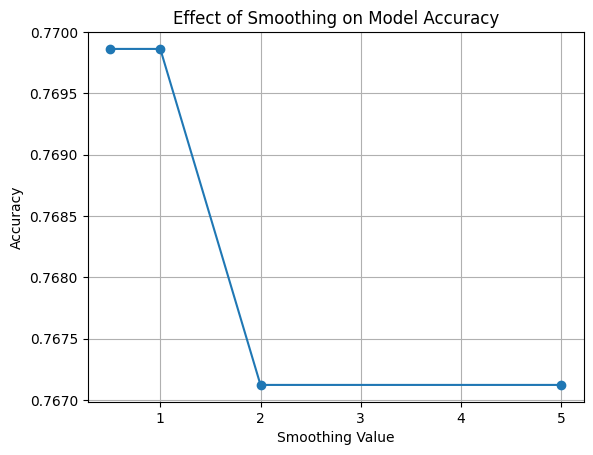

In [20]:
import matplotlib.pyplot as plt
import numpy as np

class NaiveBayesClassifier:
    def __init__(self, Pred, Pred_c, index, smoothing=1):
        self.Pred = Pred
        self.Pred_c = Pred_c
        self.index = index
        self.smoothing = smoothing

    def predict(self, text):
        words = set(tokenize(text))

        # Handle empty texts
        if len(words) == 0:
            return "No prediction (empty text)"

        # Check if all words are rare words
        if all(word not in self.index for word in words):
            return "No prediction (only rare words)"

        scores = {}
        for class_label, class_probs in self.Pred_c.items():
            score = 0
            for word in words:
                if word in self.index:
                    word_prob = self.Pred.get(word, 0)
                    class_word_prob = class_probs.get(word, 0)
                    adjusted_prob = (class_word_prob + self.smoothing) / (word_prob + self.smoothing * len(self.index))
                    score += np.log(adjusted_prob)
            scores[class_label] = score
        return max(scores, key=scores.get)
    
    def p_p(self, text):
        words = set(tokenize(text))
        if len(words) == 0:
            return 0.5

        scores = {}
        for class_label, class_probs in self.Pred_c.items():
            score = 0
            for word in words:
                if word in self.index:
                    word_prob = self.Pred.get(word, 0)
                    class_word_prob = class_probs.get(word, 0)
                    adjusted_prob = (class_word_prob + self.smoothing) / (word_prob + self.smoothing * len(self.index))
                    score += np.log(adjusted_prob)
            scores[class_label] = score

        # Apply softmax to convert scores to probabilities
        max_score = max(scores.values())
        exp_scores = {class_label: np.exp(score - max_score) for class_label, score in scores.items()}
        sum_exp_scores = sum(exp_scores.values())
        probabilities = {class_label: exp_score / sum_exp_scores for class_label, exp_score in exp_scores.items()}

        return probabilities[1]

def evaluate_classifier(smoothing_value):
    classifier = NaiveBayesClassifier(Pred, Pred_c, index, smoothing=smoothing_value)
    correct_predictions = 0
    for _, row in dev_data.iterrows():
        prediction = classifier.predict(row['text'])
        if prediction == row['generated']:
            correct_predictions += 1
    return correct_predictions / len(dev_data)

# Test different smoothing values
smoothing_values = [0.5, 1, 2, 5]
accuracies = []

for value in smoothing_values:
    accuracy = evaluate_classifier(value)
    accuracies.append(accuracy)
    print(f"Accuracy with smoothing {value}: {accuracy}")

# Plotting
plt.plot(smoothing_values, accuracies, marker='o')
plt.xlabel('Smoothing Value')
plt.ylabel('Accuracy')
plt.title('Effect of Smoothing on Model Accuracy')
plt.grid(True)
plt.show()


Experimentation and Identifying Top Predictive Words

In [21]:
def top_predictive_words(Pred_c, Pred, class_label, top_n=10):
    word_importance = {}
    for word, prob in Pred_c[class_label].items():
        # Calculate the importance of word for a class
        total_prob = Pred[word]
        if total_prob > 0:
            word_importance[word] = prob / total_prob

    sorted_words = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)
    return sorted_words[:top_n]

# Use this function to find top words
top_words_human = top_predictive_words(Pred_c, Pred, 0)
top_words_llm = top_predictive_words(Pred_c, Pred, 1)

print("Top Predictive Words for Human:", top_words_human)
print("Top Predictive Words for LLM:", top_words_llm)

Top Predictive Words for Human: [('plumer', 1.3333333333333335), ('know', 1.3333333333333335), ('decides', 1.3333333333333335), ('official', 1.3333333333333335), ('myself', 1.3333333333333335), ('could', 1.3333333333333335), ('he', 1.3333333333333335), ('says', 1.3333333333333335), ('you', 1.3333333333333335), ('my', 1.3333333333333335)]
Top Predictive Words for LLM: [('planetary', 4.0), ('missions', 4.0), ('debris', 4.0), ('captivate', 4.0), ('discovery', 4.0), ('collaboration', 4.0), ('imagination', 4.0), ('exploration', 4.0), ('poised', 4.0), ('cryptography', 4.0)]
